# Car-Sharing Service

Let's imagine a car-sharing service using Shared Autonomous Vehicles (SAVs) operating in Toronto.

Under this SAV model, The car-sharing platform would dispatch its autonomous vehicles from **depots** to **pickup locations**, driving the passenger to a **dropoff location**, and then proceeding either to the next passenger, or returning to the depot.

Let's define the following parameters to our example problem:

1. Let's assume there are 10 vehicle depots scattered around the city of Toronto.
2. There are also 10 passengers at different locations all waiting for an SAV.
3. The goal is to assign vehicles to passengers in such a way to optmize for some constraints.

Additionally, let's consider the following:
* Each SAV can seat 4 passengers, so multipassenger trips may be possible.
* Each depot  can only accomodate one SAV at a time.
* Gas costs 0.3 per unit of distance.
* SAVs earn 0.8 per unit of distance.
* SAVs travel at an average speed of 0.5 units of distance per unit of time.

For this example, we'll implement GA. For the time being, we'll also limit trips to single passenger only; this simplifies the solution.

In [3]:
import pandas as pd
from smart_mobility_utilities.poi import poi

# Import location data
depots = pd.read_csv("carshare/carshare_depot.csv")
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
pickups = pd.read_csv("carshare/carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("carshare/carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

## Utility Functions

First, let's define some useful functions that will be used in our implementation.

### Crossover and Mutation
We will use an Order 1 Crossover with a Swap Mutation for this implementation.

In [4]:
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation

### Distance
We can define the distance from one stop to the next as simply the driving distance, as calculated by `osrm`. 

In [5]:
from smart_mobility_utilities.poi import poi
def distance(start,end):
    # We can use the poi class that depends on osrm routing between two nodes
    return start.route_to(end)['length']
    

We can, however, store these distances in a trip matrix, as `osrm` is rather slow.

In [6]:
tm = pd.read_csv("carshare/trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]

### Random Solution Generation
We can generate a random "solution" by defining the number of passengers it needs to serve.

In [7]:
def find_depots(route): 
    start = route[0]
    end = route[-1]
    distances_to_start = [trip_matrix[x][start] for x in depot_nodes]
    distances_from_end = [trip_matrix[end][x] for x in depot_nodes]
    start_depot = depot_nodes[distances_to_start.index(min(distances_to_start))]
    end_depot = depot_nodes[distances_from_end.index(min(distances_from_end))]
    route = [start_depot] + route + [end_depot]
    return route

In [8]:
import random
def random_solution(depots,pickups,dropoffs,n):
    route = []
    can_visit = pickups.copy()
    for i in range(n):
        # select a random pickup location
        random_pickup = random.choice(can_visit)
        route.append(random_pickup)
        can_visit.pop(can_visit.index(random_pickup))
        
    # now we can choose the depot closest to starting and ending locations
    route = find_depots(route)
    return route
            

### Fitness

We can define the fitness of a solution in terms of its real world cost. Since the only cost provided above is the cost of gas, which is directly related to distance travelled, we can consider total fleet distance as a variable to minimize. It may also be interesting to minimize overall mileage on the fleet for the purposes of maintenance, but this too is essentially a minimization of total fleet distance.

Let's assume that the **number** of vehicles is not a cost driver. That is to say, driving 4 km on one vehicle is more costly than driving 1 km on two vehicles, and equivalent to driving 2 km on two vehicles. This favours using more vehicles whenever convenient, which also minimizes passengers per vehicle (the maximum is 4 per vehicle, but maybe we prefer less?).

To that end, the cost of driving is as follows:

$ C = g \times \sum_{n=1}^{N} \sum_{j=1}^{S_n} \sum_{k=1}^{len(S_n)-1} distance(S_n^k,S_n^{k+1})$

Where
* $N=$ total number of vehicles being used
* $S_n=$ list of stops for vehicle $n$, where $S_n^k$ is the $k$ th stop for vehicle $n$
* $g=$ the cost of fuel per distance

However, we also *earn* money from driving, as long as we have a passenger in the vehicle. This means:

$ R = r \times \sum_{n=1}^{N} \sum_{j=1}^{S_n} \sum_{k=1}^{len(S_n)-1} distance(S_n^k,S_n^{k+1})$

Where
* $N=$ total number of vehicles being used
* $S_n=$ list of stops for vehicle $n$, where $S_n^k$ is the $k$ th stop for vehicle $n$ **AND** $S_n^k$ is a pickup, and $S_n^{k+1}$ is a dropoff. This means we *don't* make money when the car is going from dropoff to the next pickup, and we don't make money to and from the depots.
* $g=$ the cost of fuel per distance

Profit is the calculated as being $P=R-C$

In [9]:
def expand_route(route, pickups, dropoffs):
    actual_route = []
    for stop in route:
        if stop not in pickups:
            # It is a depot
            actual_route.append(stop)
            continue
        actual_route.append(stop)
        drop = dropoffs[pickups.index(stop)]
        actual_route.append(drop)
    return actual_route

In [10]:
def fitness(solutions, trip_matrix):
    result = []
    for vehicle_route in solutions:
        # We need to expand the routes into pickup-dropoffs to calculate actual cost
        expanded_route = expand_route(vehicle_route, pickup_nodes, dropoff_nodes)
        total = 0
        for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
            if stop in pickup_nodes and next_stop in dropoff_nodes:
                cost_factor = 0.5
            else:
                cost_factor = -0.3
            total += cost_factor * trip_matrix[stop][next_stop]
        result.append(total)
    return result

## Solution using Genetic Algorithm (Single Vehicle)

In [15]:
# Initialize some parameters
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

The problem can be further defined as a problem of passenger allocation. For a one-vehicle solution, all 17 passengers are allocated to the lone vehicle. In this case, the vehicle must find the shortest route from the first depot, through all 17 pickup and dropoff locations, and finally back to a depot.

For any solution with $n\ge2$ vehicles, each vehicle gets one or more passengers assigned to it, and must go from its initial depot, through its assigned passengers, and terminate at an available station.

Let's try it first with only 1 vehicle:

In [16]:
# Generate initial population
population = [random_solution(depot_nodes,pickup_nodes,dropoff_nodes,10) for _ in range(pop_size)]
costs = fitness(population, trip_matrix)
costs

[16.490000000002397,
 -4187.53,
 -1417.2099999999987,
 13422.649999999998,
 7920.830000000001,
 2463.0499999999993,
 5650.340000000002,
 4735.219999999999,
 10017.439999999999,
 10417.430000000002,
 3814.190000000004,
 8336.75,
 6662.540000000001,
 4000.6100000000015,
 4255.9400000000005,
 5830.1]

In [17]:
from heapq import nlargest

states = []
# The main genetic algorithm
for _ in range(iterations):
    costs = fitness(population, trip_matrix)
    states.append(max(costs))
    # Select the parents, we want to maximize the profit
    parents = nlargest(num_parents,population, key=lambda x: costs[population.index(x)])
    # Need to remove depots from the routes
    parents = [x[1:-1] for x in parents]
    offspring = []
    new_population = []
    for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
        # Crossover probability
        if random.random() < crossover_prob:
            offspring.append(ordOne_crossover(p1,p2))
            offspring.append(ordOne_crossover(p2,p1))
        else:
            offspring.append(p1)
            offspring.append(p2)
    for child in offspring:
        if random.random() < mutation_prob:
            new_population.append(swap_mutation(child))
        else:
            new_population.append(child)
    new_population.extend(parents)
    population = [find_depots(route) for route in new_population]
    

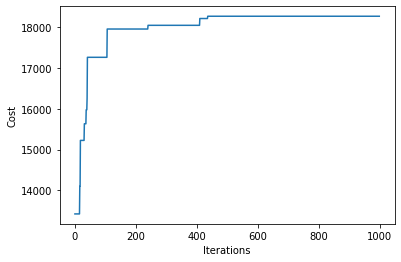

In [18]:
import matplotlib.pyplot as plt
plt.plot(states)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

In [19]:
costs = fitness(population, trip_matrix)
route = max(population,key= lambda x: costs[population.index(x)])
print("Cost of route:", costs[population.index(route)])
# expand the route
route = expand_route(route,pickup_nodes,dropoff_nodes)

from smart_mobility_utilities.poi import drawRouteOrder
# define marker colors
colors = []
for stop in route:
    if stop in depot_nodes:
        colors.append('blue')
    if stop in pickup_nodes:
        colors.append('green')
    if stop in dropoff_nodes:
        colors.append('red')
drawRouteOrder([x.coordinates[::-1] for x in route],route,range(1,len(route)+1), colors=colors)



Cost of route: 18265.37


As you can see, this solution prioritizes finding pickup locations that are close to previous dropoff locations, thus minimizing time driving without a passenger.

## Solution using genetic algorithm (n vehicles, n>1)

If we approach this problem using $n$ vehicles, it is essentially a problem of:
* how to allocate trips to each vehicle
* how to order the trips for each vehicle to maximize profit.

Additionally, we now need to respect the limitation that once a vehicle is parked at a depot, the depot is considered "full" and cannot accomodate another vehicle. This means that the $n$ vehicles must start at different locations and end at different locations.

### Random Solution Generation (Initial Population)
There are some challenges to generating the initial population when using multiple vehicles. We are constrained by the available depots, as well as the fact that for $n$ vehicles, each vehicle must have at least one trip (otherwise the solution would not contain $n$ active vehicles).


In [64]:
# Distribute the stops across n vehicles
from pprint import pprint
def distribute_stops(n, stops):
    vehicles = []
    allocated = 0
    available_stops = stops.copy()
    maximum = len(stops) - n + 1 # We initially can't allocate more than this to one stop
    for i in range(n):
        to_allocate = random.randint(1,maximum)
        if i == n-1:
            to_allocate = len(available_stops)
        chosen = random.sample(available_stops,to_allocate)
        [available_stops.pop(available_stops.index(x)) for x in chosen]
        vehicles.append(chosen)
        allocated += to_allocate
        maximum = maximum-to_allocate+1
    return vehicles
